In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import scipy.misc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from keras.models import Sequential
import keras.optimizers as opt
from keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.layers import Input

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import RandomUniform, GlorotUniform, Constant, Identity

In [ ]:
! unzip /content/drive/MyDrive/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
import cv2

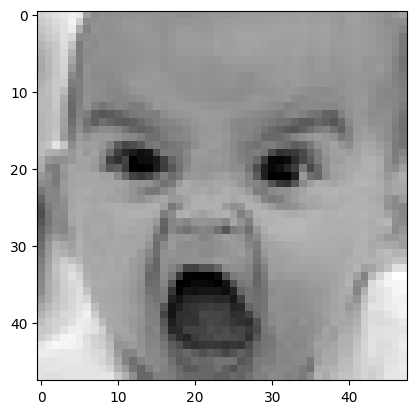

In [ ]:
img_array=cv2.imread("/content/train/angry/Training_233976.jpg")
plt.imshow(img_array)

In [ ]:
import os
from PIL import Image
train_dir= "/content/train"
test_dir= "/content/test"

In [ ]:
def load_images_and_labels_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_path = os.path.join(folder, label)
        if os.path.isdir(label_path):
            for filename in os.listdir(label_path):
                img = Image.open(os.path.join(label_path, filename))
                if img is not None:
                    images.append(img)
                    labels.append(label)
    return images, labels
train_images, train_labels = load_images_and_labels_from_folder(train_dir)
test_images, test_labels= load_images_and_labels_from_folder(test_dir)

In [ ]:
print(len(train_images))
print(len(test_images))

28709
7178


In [ ]:
new_size = (48, 48)

train_images = [img.resize(new_size) for img in train_images]
test_images = [img.resize(new_size) for img in test_images]
train_data = np.array([np.array(img) for img in train_images])
test_data = np.array([np.array(img) for img in test_images])

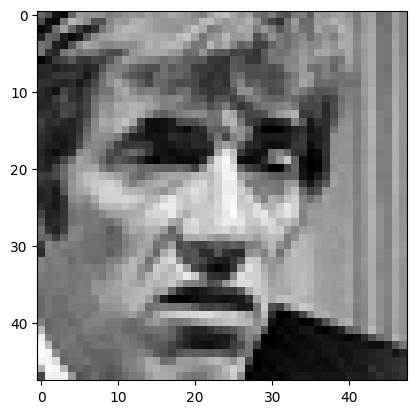

In [ ]:
plt.imshow(np.array(train_images[0], dtype = 'uint8').reshape(48,48,1), cmap = 'gray')

In [ ]:
train_data = train_data / 255.0
test_data = test_data / 255.0

In [ ]:
# Define a mapping dictionary for label conversion
label_to_index = {
    "angry": 0,
    "disgust": 1,
    "fear": 2,
    "happy": 3,
    "neutral": 4,
    "sad": 5,
    "surprise": 6
}
# Convert the text labels to numerical labels
train_labels= [label_to_index[label] for label in train_labels]
test_labels = [label_to_index[label] for label in test_labels]

In [ ]:
# Shuffle the indices of the dataset
num_train_samples = len(train_data)
num_test_samples = len(test_data)

train_indices = np.arange(num_train_samples)
test_indices = np.arange(num_test_samples)

np.random.shuffle(train_indices)
np.random.shuffle(test_indices)

# Use the shuffled indices to shuffle the data and labels
shuffled_train_data = train_data[train_indices]
shuffled_train_labels = np.array(train_labels)[train_indices]

shuffled_test_data = test_data[test_indices]
shuffled_test_labels = np.array(test_labels)[test_indices]


In [ ]:
X_train = np.array(shuffled_train_data, dtype = 'uint8')
y_train = np.array(shuffled_train_labels, dtype = 'uint8')
X_test = np.array(shuffled_test_data, dtype = 'uint8')
y_test = np.array(shuffled_test_labels, dtype = 'uint8')

In [ ]:
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [ ]:
y_train_one_hot = tf.one_hot(y_train, depth=7)
y_test_one_hot = tf.one_hot(y_test, depth=7)

In [ ]:
datagen = ImageDataGenerator(
    rotation_range = 10,
    horizontal_flip = True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode = 'nearest')

testgen = ImageDataGenerator()
datagen.fit(X_train)
batch_size = 64

In [ ]:
train_flow = datagen.flow(X_train, y_train_one_hot, batch_size=batch_size)
test_flow = testgen.flow(X_test, y_test_one_hot, batch_size=batch_size)

In [ ]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import concatenate
from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from keras.layers import ZeroPadding2D
from keras.layers import Activation
from keras.layers import Add
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor

Resnet 18 architecture

In [ ]:
def identity_block18(X, filters, initializer=random_uniform):
    # Retrieve Filters
    F1, F2 = filters
    # Save the input value. We will need this later to add back to the main path.
    X_shortcut = X
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)

    X = Conv2D(filters=F2,kernel_size=3,strides=(1,1),padding="same",kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)

    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block18(X, filters, initializer=glorot_uniform,s=2):
    F1, F2 = filters

    # Save the input value
    X_shortcut = X

    X = Conv2D(filters = F1, kernel_size = 1, strides = s, padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2,kernel_size=(3,3),strides=(1,1),padding='same',kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation("relu")(X)

    X_shortcut = Conv2D(filters=F2,kernel_size=1,strides=s,padding='valid',kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut =  BatchNormalization(axis=3)(X_shortcut)

    # Final step: Adding shortcut value to main path,and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet18(input_shape = (48,48,1), classes = 7, training=False):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, filters = [64, 64],s=1)
    X = identity_block(X, filters = [64, 64])

    X = convolutional_block(X, filters =  [128,128])
    X = identity_block(X, filters =  [128,128])

    # the 3 `identity_block`
    # add `convolutional_block`
    X = convolutional_block(X, filters = [256, 256])
    X = identity_block(X, filters = [256, 256])

   # add `convolutional_block`
    X = convolutional_block(X, filters =[512, 512])
    X = identity_block(X, filters =[512, 512])

    X = AveragePooling2D((2,2))(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model


Resnet 50 architecture

In [ ]:
def identity_block(X, f, filters, initializer=random_uniform):
    """Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer

    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    # Retrieve Filters
    F1, F2, F3 = filters
    # Save the input value. We will need this later to add back to the main path.
    X_shortcut = X
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)
    ## Set the padding = 'same'
    X = Conv2D(filters=F2,kernel_size=f,strides=(1,1),padding="same",kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
   ## Set the padding = 'valid'
    X = Conv2D(filters=F3,kernel_size=1,strides=1,padding='valid',kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    ## Final step: Adding shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    return X

In [ ]:
def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform):
    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path glorot_uniform
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s,s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Second component of main path
    X = Conv2D(filters=F2,kernel_size=(f,f),strides=(1,1),padding='same',kernel_initializer=initializer(seed=0))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation("relu")(X)

    ## Third component of main path
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X =  BatchNormalization(axis=3)(X)

    ##### SHORTCUT PATH #####
    X_shortcut = Conv2D(filters=F3,kernel_size=1,strides=(s,s),padding='valid',kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut =  BatchNormalization(axis=3)(X_shortcut)

    # Final step: Adding shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [ ]:
def ResNet50(input_shape = (48,48,1), classes = 7, training=False):
    X_input = Input(input_shape)
    X = ZeroPadding2D((3, 3))(X_input)
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    X = convolutional_block(X, f = 3, filters =  [128,128,512], s = 2)
    # the 3 `identity_block`
    X =  identity_block(X, 3,  [128,128,512] )
    X =  identity_block(X, 3,  [128,128,512] )
    X =  identity_block(X, 3,  [128,128,512] )
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    # the 5 `identity_block`
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = convolutional_block(X, f = 3, filters =[512, 512, 2048], s = 2)
    # the 2 `identity_block`
    X =identity_block(X, 3,[512, 512, 2048])
    X = identity_block(X, 3,[512, 512, 2048])
    X = AveragePooling2D((2,2))(X)
    # output layer
    X = Flatten()(X)
    X = Dense(7, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    # Create model
    model = Model(inputs = X_input, outputs = X)
    return model

In [ ]:
tf.keras.backend.set_learning_phase(True)

model = ResNet50(input_shape = (48,48,1), classes = 7)
opt = tf.keras.optimizers.Adam(learning_rate=0.00015)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Resnet 50 accuracy

In [ ]:
model.fit(X_train, y_train_one_hot, epochs = 50, batch_size = 32)

Epoch 1/50
898/898 [==============================] - 87s 51ms/step - loss: 2.0066 - accuracy: 0.2363
Epoch 2/50
898/898 [==============================] - 44s 49ms/step - loss: 1.8939 - accuracy: 0.2468
Epoch 3/50
898/898 [==============================] - 46s 51ms/step - loss: 1.8825 - accuracy: 0.2504
Epoch 4/50
898/898 [==============================] - 44s 49ms/step - loss: 1.8648 - accuracy: 0.2544
Epoch 5/50
898/898 [==============================] - 43s 48ms/step - loss: 1.8728 - accuracy: 0.2505
Epoch 6/50
898/898 [==============================] - 44s 49ms/step - loss: 1.8644 - accuracy: 0.2520
Epoch 7/50
898/898 [==============================] - 44s 48ms/step - loss: 1.8398 - accuracy: 0.2541
Epoch 8/50
898/898 [==============================] - 43s 48ms/step - loss: 1.8055 - accuracy: 0.2605
Epoch 9/50
898/898 [==============================] - 44s 49ms/step - loss: 1.8044 - accuracy: 0.2594
Epoch 10/50
898/898 [==============================] - 44s 49ms/step - loss: 1.808

In [ ]:
model.save('/content/drive/MyDrive/emotiondetection.keras')

Resnet 18 accuracy

In [ ]:
model.fit(X_train, y_train_one_hot, epochs = 10, batch_size = 32)

Epoch 1/10
898/898 [==============================] - 17s 19ms/step - loss: 1.3768 - accuracy: 0.4402
Epoch 2/10
898/898 [==============================] - 15s 17ms/step - loss: 1.3637 - accuracy: 0.4474
Epoch 3/10
898/898 [==============================] - 15s 17ms/step - loss: 1.3396 - accuracy: 0.4565
Epoch 4/10
898/898 [==============================] - 15s 17ms/step - loss: 1.3272 - accuracy: 0.4614
Epoch 5/10
898/898 [==============================] - 15s 17ms/step - loss: 1.3195 - accuracy: 0.4628
Epoch 6/10
898/898 [==============================] - 15s 17ms/step - loss: 1.3130 - accuracy: 0.4675
Epoch 7/10
898/898 [==============================] - 15s 17ms/step - loss: 1.3084 - accuracy: 0.4691
Epoch 8/10
898/898 [==============================] - 15s 17ms/step - loss: 1.2880 - accuracy: 0.4770
Epoch 9/10
898/898 [==============================] - 15s 17ms/step - loss: 1.2910 - accuracy: 0.4746
Epoch 10/10
898/898 [==============================] - 15s 17ms/step - loss: 1.288

In [ ]:
model.fit(X_train, y_train_one_hot, epochs = 50, batch_size = 32)

Epoch 1/50
898/898 [==============================] - 16s 17ms/step - loss: 1.2758 - accuracy: 0.4802
Epoch 2/50
898/898 [==============================] - 15s 17ms/step - loss: 1.2736 - accuracy: 0.4802
Epoch 3/50
898/898 [==============================] - 16s 18ms/step - loss: 1.2715 - accuracy: 0.4807
Epoch 4/50
898/898 [==============================] - 15s 17ms/step - loss: 1.2723 - accuracy: 0.4800
Epoch 5/50
898/898 [==============================] - 15s 17ms/step - loss: 1.2652 - accuracy: 0.4814
Epoch 6/50
898/898 [==============================] - 17s 19ms/step - loss: 1.2562 - accuracy: 0.4852
Epoch 7/50
898/898 [==============================] - 15s 17ms/step - loss: 1.2652 - accuracy: 0.4827
Epoch 8/50
898/898 [==============================] - 15s 17ms/step - loss: 1.2559 - accuracy: 0.4852
Epoch 9/50
898/898 [==============================] - 15s 17ms/step - loss: 1.2567 - accuracy: 0.4849
Epoch 10/50
898/898 [==============================] - 15s 17ms/step - loss: 1.255

In [ ]:
model.evaluate(X_test,y_test_one_hot)

225/225 [==============================] - 6s 16ms/step - loss: 2.6367 - accuracy: 0.2747


[2.636678695678711, 0.27472832798957825]

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo4.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo4.jpg


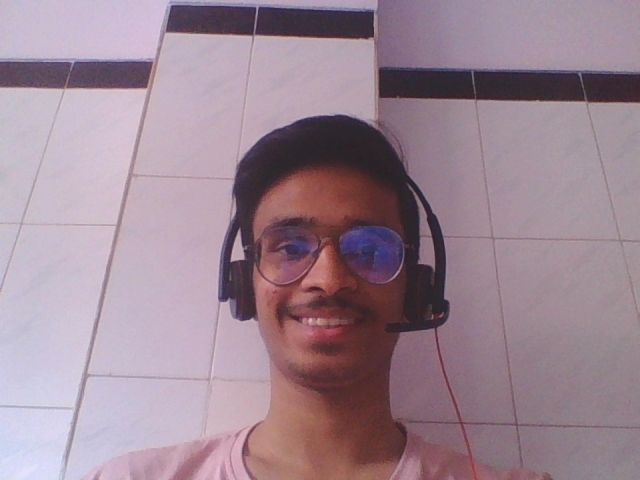

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
import cv2
from keras.models import model_from_json
from google.colab.patches import cv2_imshow
import numpy as np

json_file = open("facialemotionmodel.json", "r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)

model.load_weights("/content/drive/MyDrive/facialemotionmodel.h5")
haar_file = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(haar_file)

def extract_features(image):
    feature = np.array(image)
    feature = feature.reshape(1, 48, 48, 1)
    return feature / 255.0

1/1 [==============================] - 0s 77ms/step


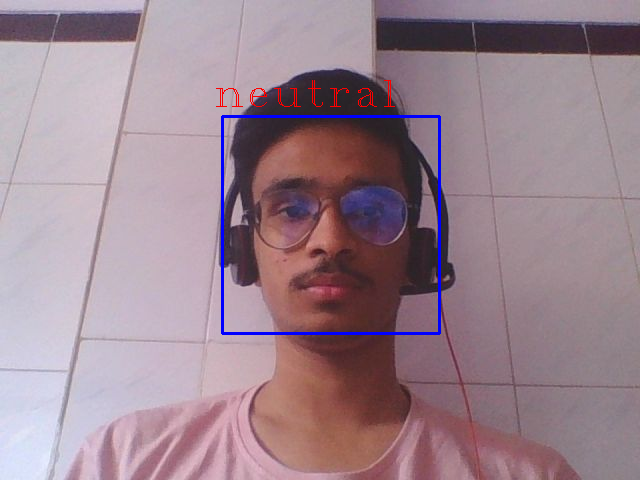

In [ ]:
image_path = "/content/photo1.jpg"
im = cv2.imread(image_path)

if im is None:
    print("Failed to read the image from file:", image_path)
else:
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(im, 1.3, 5)

    try:
        labels = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

        for (p, q, r, s) in faces:
            image = gray[q:q+s, p:p+r]
            cv2.rectangle(im, (p, q), (p+r, q+s), (255, 0, 0), 2)
            image = cv2.resize(image, (48, 48))
            img = extract_features(image)
            pred = model.predict(img)
            prediction_label = labels[pred.argmax()]
            cv2.putText(im, '% s' % (prediction_label), (p-10, q-10), cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (0, 0, 255))

        cv2_imshow(im)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    except cv2.error:
        print("Error processing the image.")

1/1 [==============================] - 0s 17ms/step


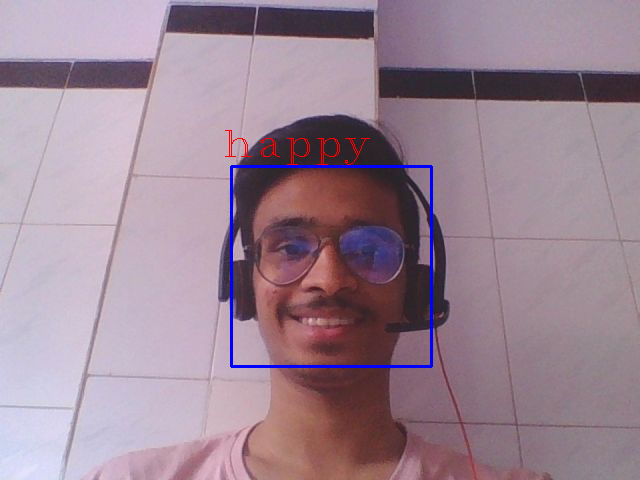

In [ ]:
image_path = "/content/photo4.jpg"
im = cv2.imread(image_path)

if im is None:
    print("Failed to read the image from file:", image_path)
else:
    gray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(im, 1.3, 5)

    try:
        labels = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}

        for (p, q, r, s) in faces:
            image = gray[q:q+s, p:p+r]
            cv2.rectangle(im, (p, q), (p+r, q+s), (255, 0, 0), 2)
            image = cv2.resize(image, (48, 48))
            img = extract_features(image)
            pred = model.predict(img)
            prediction_label = labels[pred.argmax()]
            cv2.putText(im, '% s' % (prediction_label), (p-10, q-10), cv2.FONT_HERSHEY_COMPLEX_SMALL, 2, (0, 0, 255))

        cv2_imshow(im)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

    except cv2.error:
        print("Error processing the image.")